## What is the learner, and how do we fine tune (train) a model?

At this stage we can access our data and create `DataBlocks` and `DataLoaders`. The next step is to create a model.

To do this we are going to setup a `learner` and have it **fine tune** a pre-trained model, meaning a model that already works for images.

Let's start by importing the tools we need from the fastai library.

We're also going to be using the Pytorch Image Models library in order to access other options for pre-trained models besides Resnet. Documentation can be found at [https://timm.fast.ai/](https://timm.fast.ai/).

In [1]:
from fastai.vision.all import *
import timm

Next, we'll need to know where the data is. Set the path to the data in the cell below. For this exercise, you should use the `pets` data we have previously unzipped and used in past lessons, at least the first time you're looking at this notebook. To do this, modify the code cell below to:  
`path = '/workspace/data/pets'`

If I wanted to use my own data, and my zipfile was named `IAN_DATA.zip` and created a folder called `IAN_DATA`, I would modify the assignment of `path` to be `path = /workspace/data/IAN_DATA`. The `.zip` is dropped here because we are looking at the folder that was created through the unzipping process, and not the compressed file.

In [2]:
path = '/workspace/data/NewTestData'

Now that the location of the data is set in a variable, we *might* want to verify that all of our data is image data. If you have collected and organized all of the data, and are confident you don't have any random files in the directories, you may not need this. But, it can be helpful to run it once to ensure we won't have filetype issues going forward.

In [ ]:
# only run this test if you've added new data to the training data
# it does NOT need to be run if you're confident that the image files are valid 
failed = verify_images(get_image_files(path)) # this looks at all of the files in our defined path and verifies that they are images, and failures will be placed in the failed variable
failed.map(Path.unlink) # if there are any failes that were not images, remove them from the data
len(failed) # show the number of failed files, ideally this will be 0, but even if it's more than 0 know that those files are now gone and we don't need to worry about them

Next, we'll need a `DataLoader`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it.

If you need a refresher, please visit the `01-datablocks-and-dataloaders` notebook.

In [3]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224, 'squish'), 
    batch_tfms=aug_transforms()
).dataloaders(path, bs=30)

In [ ]:
dls.show_batch(max_n=8, nrows=2, ncols=4)

## What is a learner?

We will use a learner to train a model on a pre-trained model, meaning a model that is already effective for taking images as inputs, and providing categories/labels/names as outputs. 

You can think of a learner as a toddler that is learning what things are in the world. It is going to use the `DataLoader` from above, which can be thought of the as the environment that the toddler is in, such as things it can see (images) and words that it knows (categories). This toddler/learner is then going to use a method from the pre-trained model to go about learning what categories match to which images. That analogy is not entirely correct, but it should provide some idea of how we're putting all this together.

There are many models out there, and a fast, and widely used computer vision model is `resnet18`, which is a pre-trained model that already works for other images. The `resnet18` model was trained on the ImageNet dataset, which is comprised of significantly more images and categories than we are likely to use in this trainer notebook. It is a *pre-trained* model that we can build upon, instead of needing to develop a model from scratch. The `18` referes to the number of layers in the model. Other options are `resnet34`, `resnet50`, `resnet101`, and `resnet152`. To use any of these other pre-trained models, you simply replace `resnet18` with the one you prefer below in the `vision_learner()` parameters. 
Example: `learn = vision_learner(dls, resnet101, metrics=error_rate)`

More information about pretrained models, and others that you may want to use instead of `resnet18` can be found at [https://www.kaggle.com/code/jhoward/which-image-models-are-best](https://www.kaggle.com/code/jhoward/which-image-models-are-best).

**The code below creates a learner, and in this case a vision_learner since we are working within *computer vision.***

More information about learners in can be found at [https://docs.fast.ai/learner.html](https://docs.fast.ai/learner.html).

In [4]:
learn = vision_learner(dls, resnet18, metrics=error_rate) # create the learner

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 24.1MB/s]


## What if we don't want to use a Resnet model?

There are lots of models available through the Pytorch Image Models library. Since we've already installed and imported that library, let's take a look at what is available.

We're interested in using a pre-trained model, so we need to include that as a parameter below.

In [ ]:
timm.list_models(pretrained=True)

The `levit` models looked pretty good, let's see what is available there by passing a string into the `timm.list_models()` function.

Note that the star (`*`) at the end of the string will return anything that starts with 'levit'.

In [ ]:
timm.list_models('levit*', pretrained=True)

As you can see, there are many to choose from.

Let's try to use something other than a Resnet model. Notice that we will need to provide a string to the `vision_learner` function that is the name of the pre-trained model we want to use.

If I were to choose the 'levit_384.fb_dist_in1k' model, I need some extra information, such as the required size of the images.

In [ ]:
# Model name
model_name = 'levit_384.fb_dist_in1k'

# Create the model instance
model = timm.create_model(model_name, pretrained=True)

# Retrieve the default configuration
default_cfg = model.default_cfg
print(default_cfg)

Note that the `input_size` in the configuration is `(3, 224, 224)`, which means that we will need to resize our images to `224` in the `DataBlock` parameters. Modify that code and rerun the cell if needed.

In [ ]:
learn = vision_learner(dls, 'levit_384.fb_dist_in1k', metrics=error_rate) # create the learner

Once we have a learner, we will want to find an optimal learning rate, which can be thought of as the step size to take during the learning (fine tuning). Too small of a learning rate, and it might take a long time to find the best model for our data. Too large of a learning rate and we might jump right over the best model for our data.

We will use the value that the code below (`learn.lr_find`) returns when we fine tune the model for our dataset.

More information about the learning rate can be found at [https://medium.com/@bijil.subhash/transfer-learning-how-to-pick-the-optimal-learning-rate-c8621b89c036](https://medium.com/@bijil.subhash/transfer-learning-how-to-pick-the-optimal-learning-rate-c8621b89c036).

SuggestedLRs(valley=0.001737800776027143)

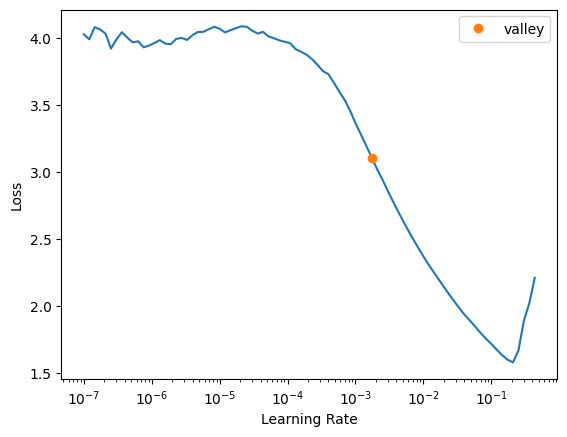

In [5]:
learn.lr_find() # find the learning rate

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

First, we need to store that learning rate value from above into a variable called `learning_rate`.

In [7]:
learning_rate = 0.001737800776027143 # use the value from the lr_find() method above

Then let's set a value for the number of epochs we want to train for and let it run.

In [8]:
initial_training_epochs = 5
learn.fine_tune(initial_training_epochs, base_lr=learning_rate) 

epoch,train_loss,valid_loss,error_rate,time
0,1.605209,0.013185,0.005376,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.047616,0.000334,0.000000,00:31
1,0.027600,0.000060,0.000000,00:30
2,0.015322,0.000022,0.000000,00:30
3,0.009528,0.000022,0.000000,00:31
4,0.006344,0.000025,0.000000,00:29


## What are train_loss, valid_loss, and error_rate?

1. train_loss:
    - **Definition:** This is the loss calculated on the training dataset.
    - **Purpose:** It measures how well the model is performing on the training data. *A lower training loss generally indicates that the model is fitting the training data well.*
    - **Calculation:** During each epoch, the model makes predictions on the training data, and the difference between these predictions and the actual targets (ground truth) is computed using a loss function (e.g., cross-entropy loss for classification tasks). This difference is the training loss.

1. valid_loss:
    - **Definition:** This is the loss calculated on the validation dataset.
    - **Purpose:** It provides an estimate of how well the model is performing on unseen data. *A lower validation loss indicates better generalization to new data.*
    - **Calculation:** After each epoch, the model's performance is evaluated on the validation set, which is separate from the training set. The predictions on the validation data are compared to the actual targets to compute the validation loss using the same loss function as for training.

1. error_rate:
    - **Definition:** This is the proportion of incorrect predictions made by the model on the validation set.
    - **Purpose:** It is a common metric for classification tasks, indicating the accuracy of the model. *A lower error rate means higher accuracy.*
    - **Calculation:** It is computed as the number of incorrect predictions divided by the total number of predictions made on the validation set. If the model predicts the wrong class for a validation example, it counts as an error.

## How did our model do?

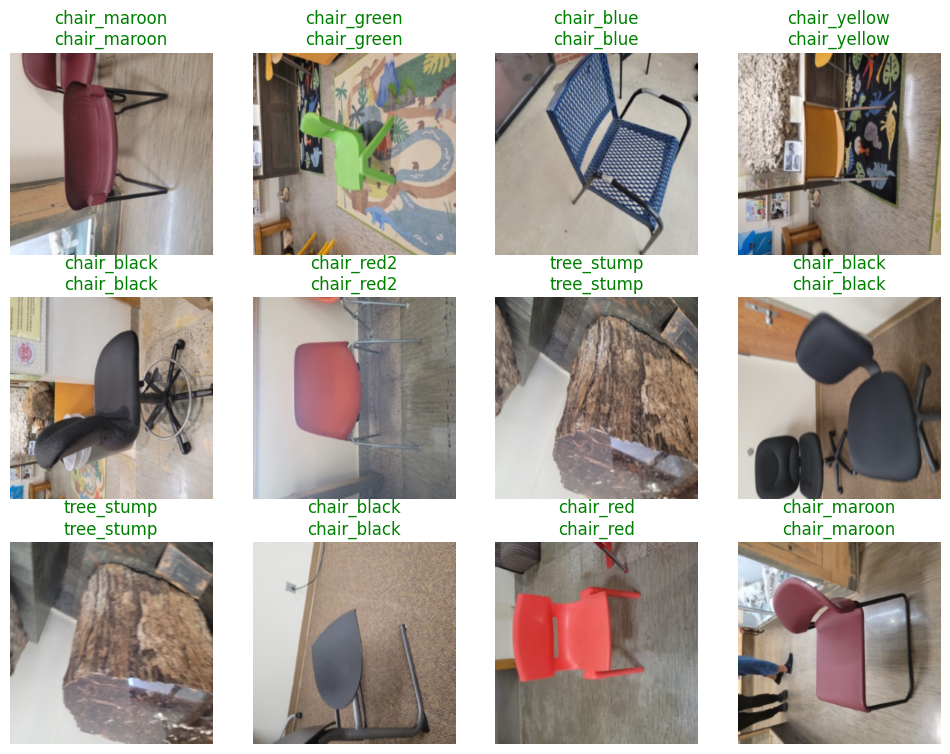

In [9]:
learn.show_results(max_n=12, nrows=3, ncols=4)

## What did the model have the most difficulty with?

To interpret the predictions for our model we will use an interpretation function. Since we are specifically interested in classification for this model (giving it a piece of data and receiving a category label), we will use the `ClassificationInterpretation` class and tell it to interpret from the learner we've been using so far.

Documentation can be found at [https://docs.fast.ai/interpret.html](https://docs.fast.ai/interpret.html).

In [10]:
interp = ClassificationInterpretation.from_learner(learn)

Now that we have our interpretation, let's examine a confusion matrix for the model. Running the cell below will show the percentage of categories that were either correctly, or incorrectly, identified. If you would prefer to see the raw numbers of elements, modify the `normalize` parameter to `False`.

You can read more about the what a confusion matrix shows at [https://www.geeksforgeeks.org/confusion-matrix-machine-learning/](https://www.geeksforgeeks.org/confusion-matrix-machine-learning/)

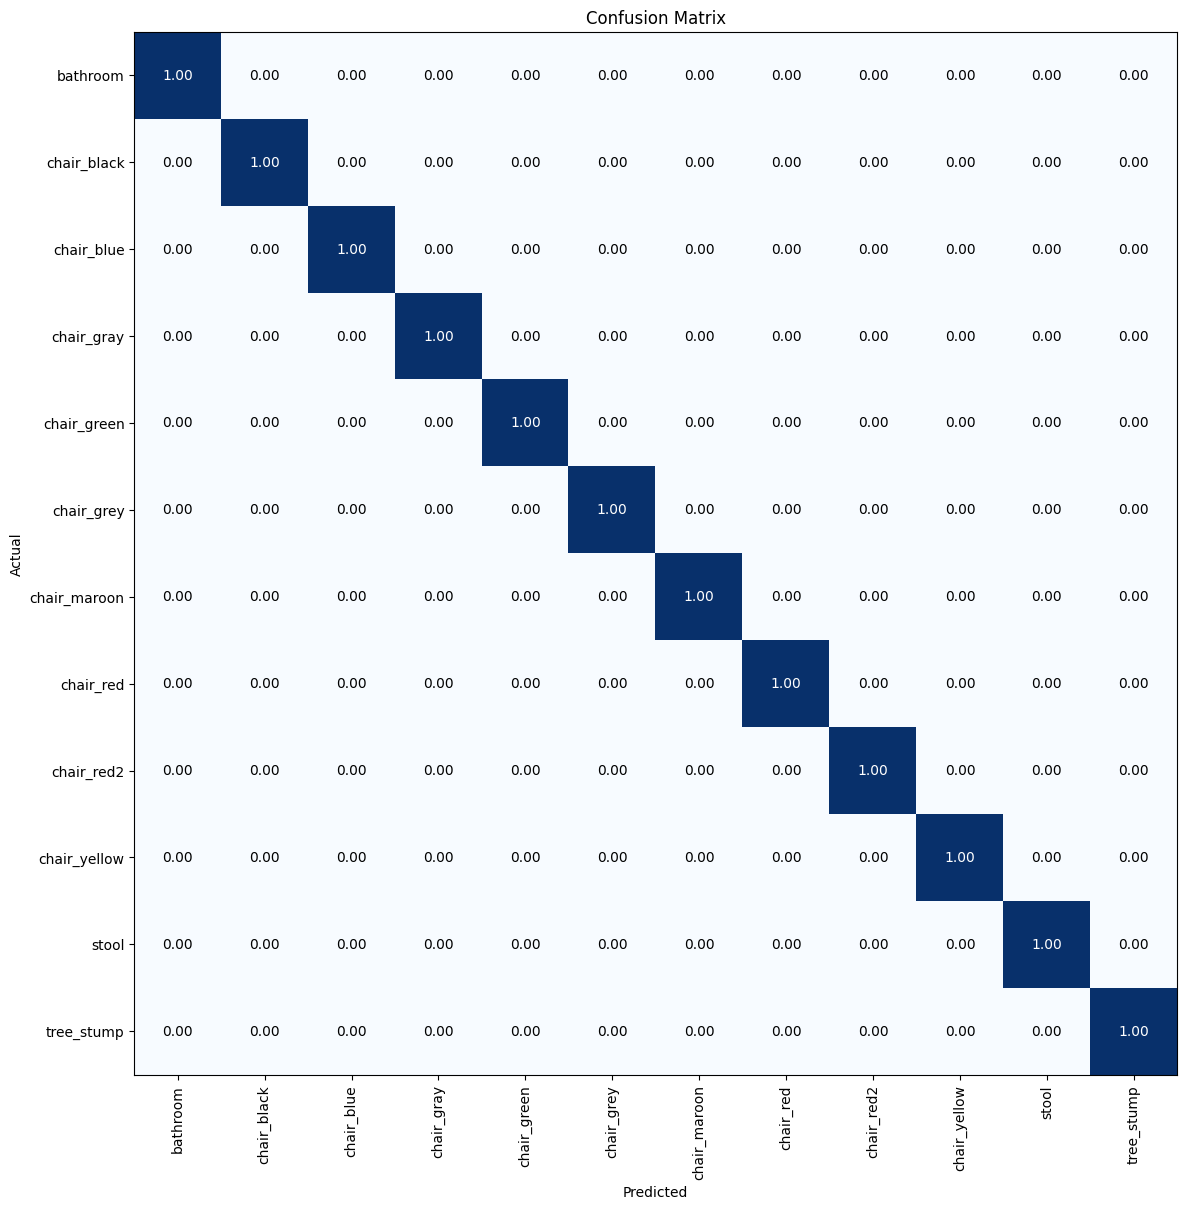

In [11]:
interp.plot_confusion_matrix(normalize=True, title='Confusion Matrix', figsize=(12, 12))

We can also use our interpretation to show items in our dataset that the model had the most trouble with. The `plot_top_losses` method below may show high confidence (probability) that an image is one category (prediction), but it was actually (actual) organized in the data as another. We will be able to clean up any mislabeled data in Step 5.

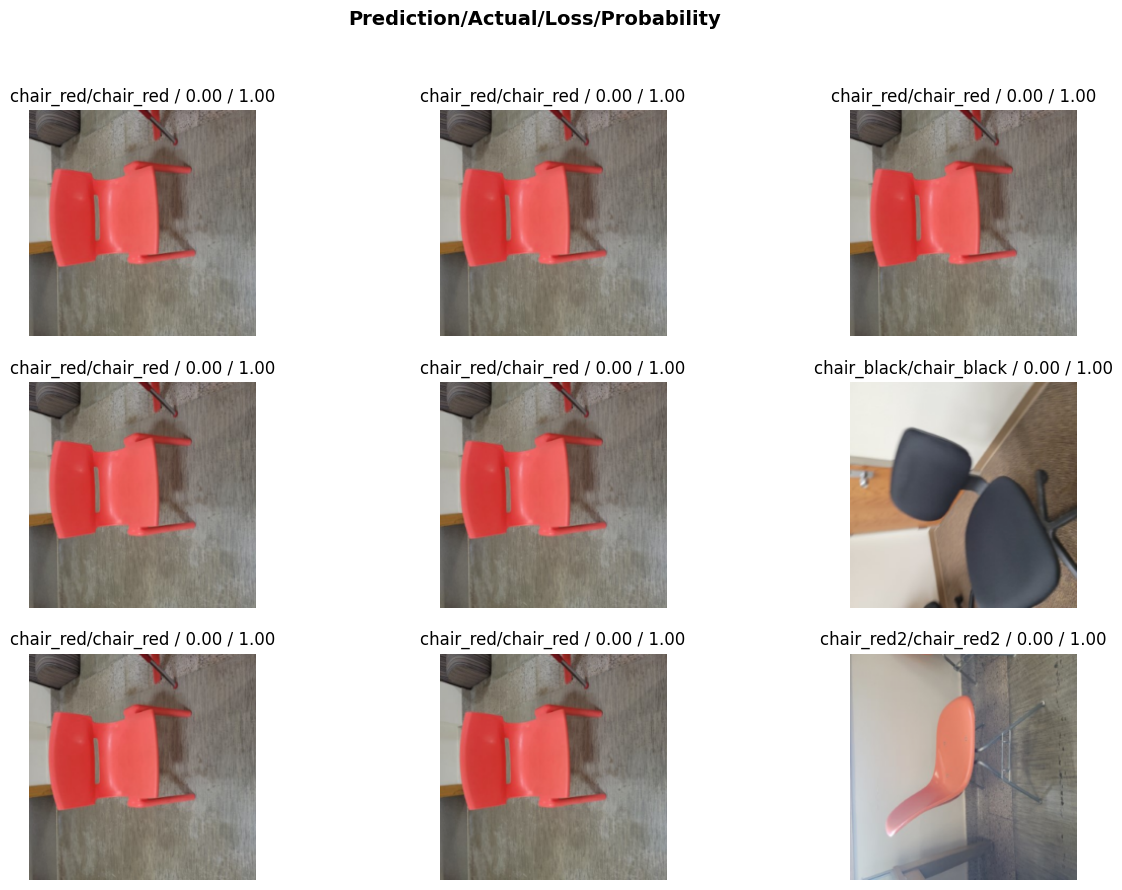

In [12]:
interp.plot_top_losses(9, figsize=(15,10))

And finally, if you want to test out individual files you can use the code below. I suggest creating a new folder called `TEST_IMAGES` in `/workspace/images/` and uploading some files to test there. This should result in an image with the filename `cat_test.jpg` having a full path of `/workspace/images/TEST_IMAGES/cat_test.jpg`.

The code below will use that path, show you a thumbnail of the image, and then use `learn.predict()` to return an identified category.

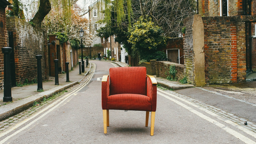

In [17]:
img_path = '/workspace/images/TEST_IMAGES/testchair.jpg'
Image.open(img_path).to_thumb(256,256)

In [18]:
category,_,probs = learn.predict(PILImage.create(img_path))
print(f"This is a: {category}.")

This is a: chair_maroon.


## How can I clean up the data? Do I have to go find those files?

At this stage, we may have identified some bad or mislabeled data. We will use the `ImageClassifierCleaner` function on our learner to let us modify any labels, or potentially remove data, directly from this notebook.

You may find that large collections of data may have been mislabeled, which may result in actually modifying the data found in `/workspace/data/`. You should feel free to do this, but you will likely want to run steps 2-3 again on this modified data. Situations like this can occur if multiple sets of data are being put into one large collection of data and end up in the wrong folder.

When using the cleaner below, you should know that what you see is organized in order of least confident, to most confident. So the first images are the most likely to be challenging for our model. Using the drop-down tool under each image, you can choose to **keep** that image with that category, **delete** it, or **move it to a new category**. You will want to examine every category, for both the training, and the validation, sets of data. 

A quick reminder that these were created using the `splitter` parameter in the `DataBlock` earlier. If you have left that code as is, this resulted in 20% of the data being used for the validation set, and 80% being used for training (`splitter=RandomSplitter(valid_pct=0.2, seed=42)`).

In [19]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

Once you have cleaned the data, the code below will use a `for` loop to enact any of the modifications you made on the data.

In [20]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Finally, if you are satisfied with your trained `Learner`, then you can export the file that contains all the information needed to use the model elsewhere, whether that be in an application or for futue training.

**However, we just cleaned the data, maybe we don't want to save this model and should start at the beginning with a cleaned up dataset.**

In [21]:
learn.export('/workspace/models/model.pkl')